In [2]:
"""
In this notebook, we analyze teh relationship between the LPIPS variance among the reconstructed images 
of an original image at a fixed token count. So, as one changes the seed, the reconstruction changes slightly,
and we assume that the higher this variance is, the harder it is to reconstruct the original image in terms of
LPIPS as a reconstruction loss.
"""

'\nIn this notebook, we analyze teh relationship between the LPIPS variance among the reconstructed images \nof an original image at a fixed token count. So, as one changes the seed, the reconstruction changes slightly,\nand we assume that the higher this variance is, the harder it is to reconstruct the original image in terms of\nLPIPS as a reconstruction loss.\n'

In [3]:
import json
import matplotlib.pyplot as plt
import math
import os
import sys
import numpy as np
import torch
from torch.utils.data import Dataset
sys.path.append(os.path.abspath("../.."))   # one level up from notebook/

from data.utils.dataloaders import ReconstructionDataset_Heuristic, get_imagenet_dataloader

Matplotlib is building the font cache; this may take a moment.
/BS/data_mani_compress/work/miniforge3/envs/dgm_geometry/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
# read reconstruction losses
with open("/BS/data_mani_compress/work/thesis/thesis/data/datasets/imagenet_reconstruction_losses/val_categorized/all_losses.json") as f:
    recon_losses = json.load(f)

In [12]:
print(recon_losses[0])

{'image_id': 0, 'k_value': 1, 'L1Loss': 0.19351771473884583, 'LPIPS': 0.6646087765693665, 'LPIPS_layers': [0.11964087188243866, 0.14834865927696228, 0.11373482644557953, 0.1480303555727005, 0.13485409319400787], 'DINOv2FeatureLoss': 0.525488018989563}


In [ ]:
list_lpips_variances = {}
k_values = [1,2,4,8,16,32,64,128,256]
for k in k_values:
    with open(f"/BS/data_mani_compress/work/thesis/thesis/data/datasets/LPIPS_variance_reconstructions/val/reconst_{k}.json") as f:
        k_variance = json.load(f)
        list_lpips_variances[k] = [v for inner in k_variance.values() for v in inner.values()]

In [6]:
mean_lpips_variances =[]
for i, k in enumerate(k_values):
    mean_lpips_variances.append(np.mean(list_lpips_variances[k]))
    print(f"Mean LPIPS variance for reconstruction at {2**i} tokens:", mean_lpips_variances[-1])


Mean LPIPS variance for reconstruction at 1 tokens: 0.6769710841935873
Mean LPIPS variance for reconstruction at 2 tokens: 0.6502344981992245
Mean LPIPS variance for reconstruction at 4 tokens: 0.5897023133307695
Mean LPIPS variance for reconstruction at 8 tokens: 0.5465329182100296
Mean LPIPS variance for reconstruction at 16 tokens: 0.507719656907171
Mean LPIPS variance for reconstruction at 32 tokens: 0.46392868218645456
Mean LPIPS variance for reconstruction at 64 tokens: 0.42555599296387286
Mean LPIPS variance for reconstruction at 128 tokens: 0.3756818894020841
Mean LPIPS variance for reconstruction at 256 tokens: 0.3221087358976714


In [7]:
# Example usage:
# Create the dataset using LPIPS variance dicts (nested) and map by image name.
# `lpips_variances_reconst_1` is a nested dict {class_id: {image_key: variance}}.
# If your `reconstruction_data` items have an "img_name" field matching those image keys,
# set `lpips_key_field="img_name"`.
print(list_lpips_variances.keys())
print(recon_losses[0])
# Example (uncomment when `reconstruction_data` is prepared):
ds = ReconstructionDataset_Heuristic(
    reconstruction_data=recon_losses,  # or your processed list of dicts
    lpips_variance_information=list_lpips_variances,
    error_key=["LPIPS"],
)
print(len(ds))
print(ds[0])  # Example access to first item

dict_keys([1, 2, 4, 8, 16, 32, 64, 128, 256])
{'image_id': 0, 'k_value': 1, 'L1Loss': 0.19351771473884583, 'LPIPS': 0.6646087765693665, 'LPIPS_layers': [0.11964087188243866, 0.14834865927696228, 0.11373482644557953, 0.1480303555727005, 0.13485409319400787], 'DINOv2FeatureLoss': 0.525488018989563}
450000
{'LPIPS': 0.6646087765693665, 'k_value': 1, 'image_id': 0, 'lpips_variance': 0.647842526435852}


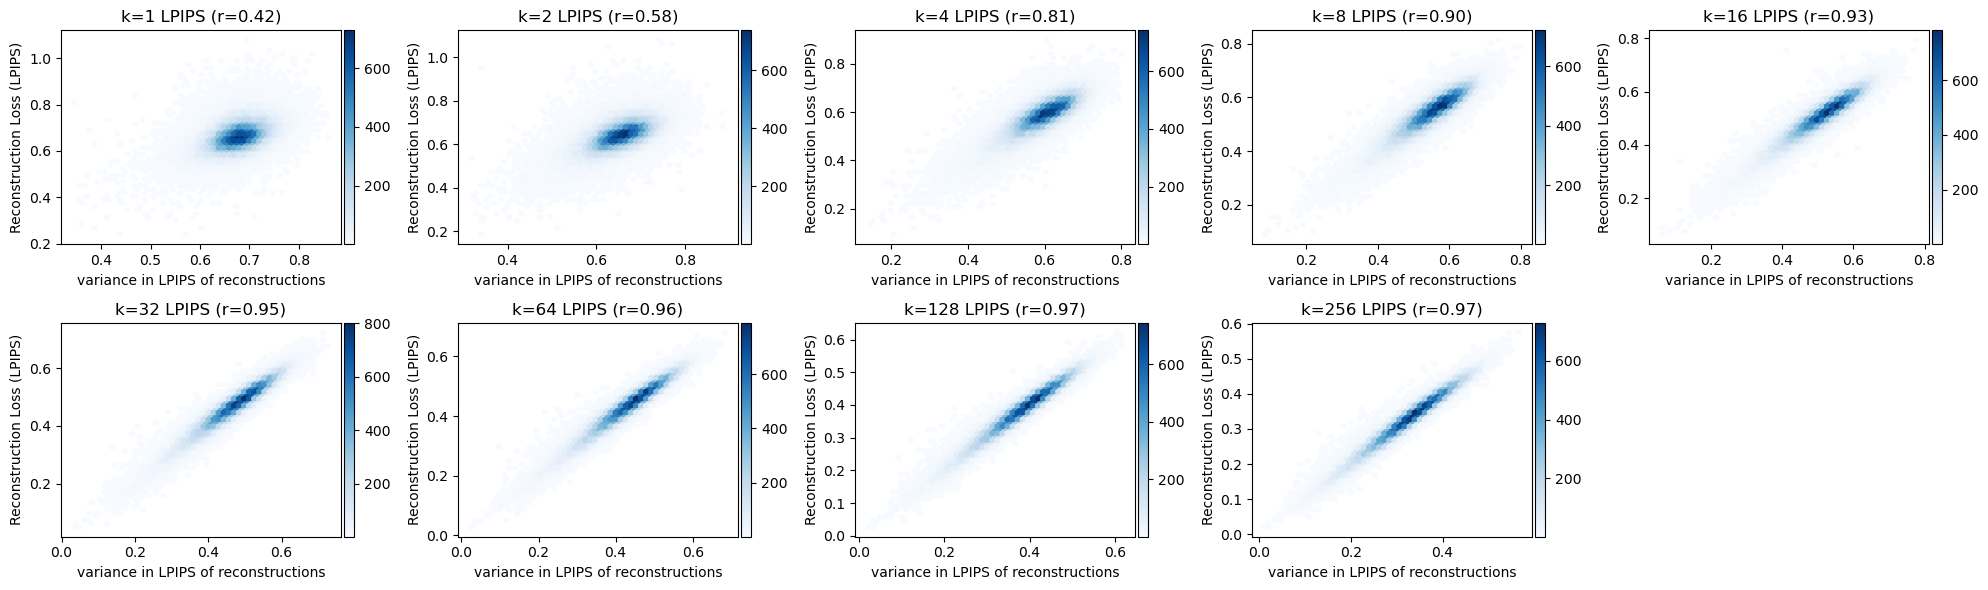

In [8]:
k_values = [1, 2, 4, 8, 16, 32, 64, 128, 256]
ncols   = 5
nrows   = int(math.ceil(len(k_values) / ncols))

fig, axes = plt.subplots(nrows, ncols, figsize=(ncols * 4, nrows * 3), squeeze=False)
axes_flat = axes.flatten()

corr = []

for idx, k in enumerate(k_values):
    ax = axes_flat[idx]
    densities    = []
    losses_lpips = []
    for data_point in ds:
        if data_point['k_value'] == k:
            densities.append(data_point['lpips_variance'])
            losses_lpips.append(data_point['LPIPS'])
    # First hexbin: LPIPS vs density
    hb1 = ax.hexbin(densities, losses_lpips, gridsize=50, cmap='Blues', mincnt=1)
    if len(densities) > 1:
        corr1 = np.corrcoef(densities, losses_lpips)[0, 1]
    else:
        corr1 = float('nan')
    ax.set_title(f"k={k} LPIPS (r={corr1:.2f})")
    ax.set_xlabel('variance in LPIPS of reconstructions')
    ax.set_ylabel('Reconstruction Loss (LPIPS)')

    corr.append(corr1)

    # Optionally add a colorbar for the first hexbin
    fig.colorbar(hb1, ax=ax, orientation='vertical', pad=0.01, fraction=0.05)

# Hide unused subplots (if grid larger than number of k_values)
for j in range(len(k_values), nrows * ncols):
    fig.delaxes(axes_flat[j])

plt.tight_layout()
plt.show()

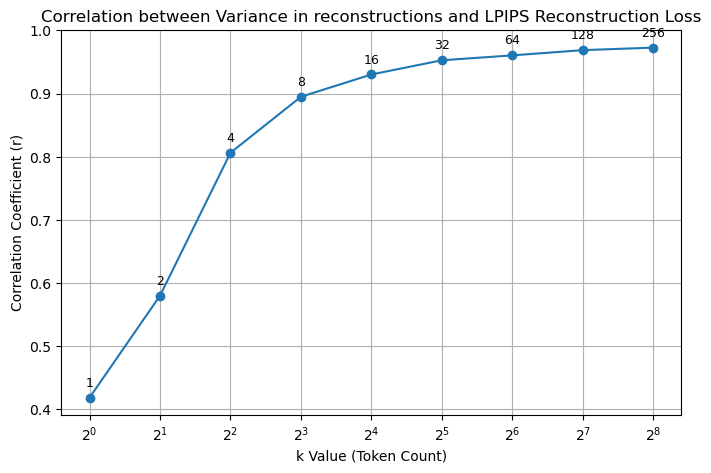

In [9]:
# plot correlation vs k_values
plt.figure(figsize=(8, 5))
plt.plot(k_values, corr, marker='o')
plt.xscale('log', base=2)
for x, y in zip(k_values, corr):
    plt.annotate(
        f"{x}",          # text (x value)
        (x, y),          # point to annotate
        textcoords="offset points",
        xytext=(0, 8),   # offset above the point
        ha='center',
        fontsize=9
    )
plt.xlabel('k Value (Token Count)')
plt.ylabel('Correlation Coefficient (r)')
plt.title('Correlation between Variance in reconstructions and LPIPS Reconstruction Loss')
plt.grid(True)
plt.savefig("/BS/data_mani_compress/work/thesis/thesis/output/lpips_variance_reconstruction_loss_relation.pdf")
plt.show()

In [11]:
from typing import Dict, Iterable, Any, Tuple

Record = Dict[str, Any]

def extremes_by_k(
    records: Iterable[Record],
    key_k: str = "k_value",
    key_v: str = "lpips_variance",
    key_id: str = "image_id",
    key_reconLoss: str = "LPIPS"
) -> Dict[int, Dict[str, Tuple[float, int]]]:
    """
    Returns:
      {
        k_value: {
          "min": (lpips_variance, image_id),
          "max": (lpips_variance, image_id),
        },
        ...
      }
    """
    out: Dict[int, Dict[str, Tuple[float, int]]] = {}

    for r in records:
        k = int(r[key_k])
        v = float(r[key_v])
        img_id = int(r[key_id])
        rl = float(r[key_reconLoss])

        if k not in out:
            out[k] = {"min": (v, img_id, rl), "max": (v, img_id, rl)}
            continue

        # Update min
        if v < out[k]["min"][0]:
            out[k]["min"] = (v, img_id, rl)

        # Update max
        if v > out[k]["max"][0]:
            out[k]["max"] = (v, img_id, rl)

    return out


ext = extremes_by_k(ds)
for k in sorted(ext):
    vmin, idmin, rl = ext[k]["min"]
    vmax, idmax, rl = ext[k]["max"]
    print(f"k={k}: min var={vmin:.4f} (image_id={idmin}), max var={vmax:.4f} (image_id={idmax})")


k=1: min var=0.3450 (image_id=4602), max var=0.8590 (image_id=16220)
k=2: min var=0.3177 (image_id=6702), max var=0.8902 (image_id=15809)
k=4: min var=0.1389 (image_id=42610), max var=0.8023 (image_id=15066)
k=8: min var=0.0840 (image_id=23503), max var=0.7957 (image_id=47299)
k=16: min var=0.0636 (image_id=42610), max var=0.7758 (image_id=40662)
k=32: min var=0.0343 (image_id=23503), max var=0.7265 (image_id=38382)
k=64: min var=0.0250 (image_id=40666), max var=0.6838 (image_id=32170)
k=128: min var=0.0209 (image_id=21128), max var=0.6168 (image_id=32112)
k=256: min var=0.0133 (image_id=21128), max var=0.5666 (image_id=25490)


In [17]:
# load the imagenet dataset to visualize these images
imagenet_dataset = get_imagenet_dataloader().dataset

In [27]:
IMAGENET_MEAN = np.array([0.485, 0.456, 0.406])
IMAGENET_STD  = np.array([0.229, 0.224, 0.225])

def denormalize_image(img):
    """
    img: torch.Tensor (C,H,W) or numpy array (H,W,C), normalized
    returns: numpy array (H,W,C) in [0,1]
    """
    if torch.is_tensor(img):
        img = img.detach().cpu().permute(1, 2, 0).numpy()

    img = img * IMAGENET_STD + IMAGENET_MEAN
    img = np.clip(img, 0.0, 1.0)
    return img

In [37]:
from collections import OrderedDict

images_by_k = OrderedDict()

for k in sorted(ext.keys()):
    min_var, min_id, min_rl = ext[k]["min"]
    max_var, max_id, max_rl = ext[k]["max"]

    images_by_k[k] = {
        "min": {
            "image": denormalize_image(imagenet_dataset[min_id][0]),
            "variance": min_var,
            "image_id": min_id,
            "lpips_recon_loss": min_rl
        },
        "max": {
            "image": denormalize_image(imagenet_dataset[max_id][0]),
            "variance": max_var,
            "image_id": max_id,
            "lpips_recon_loss": max_rl
        },
    }


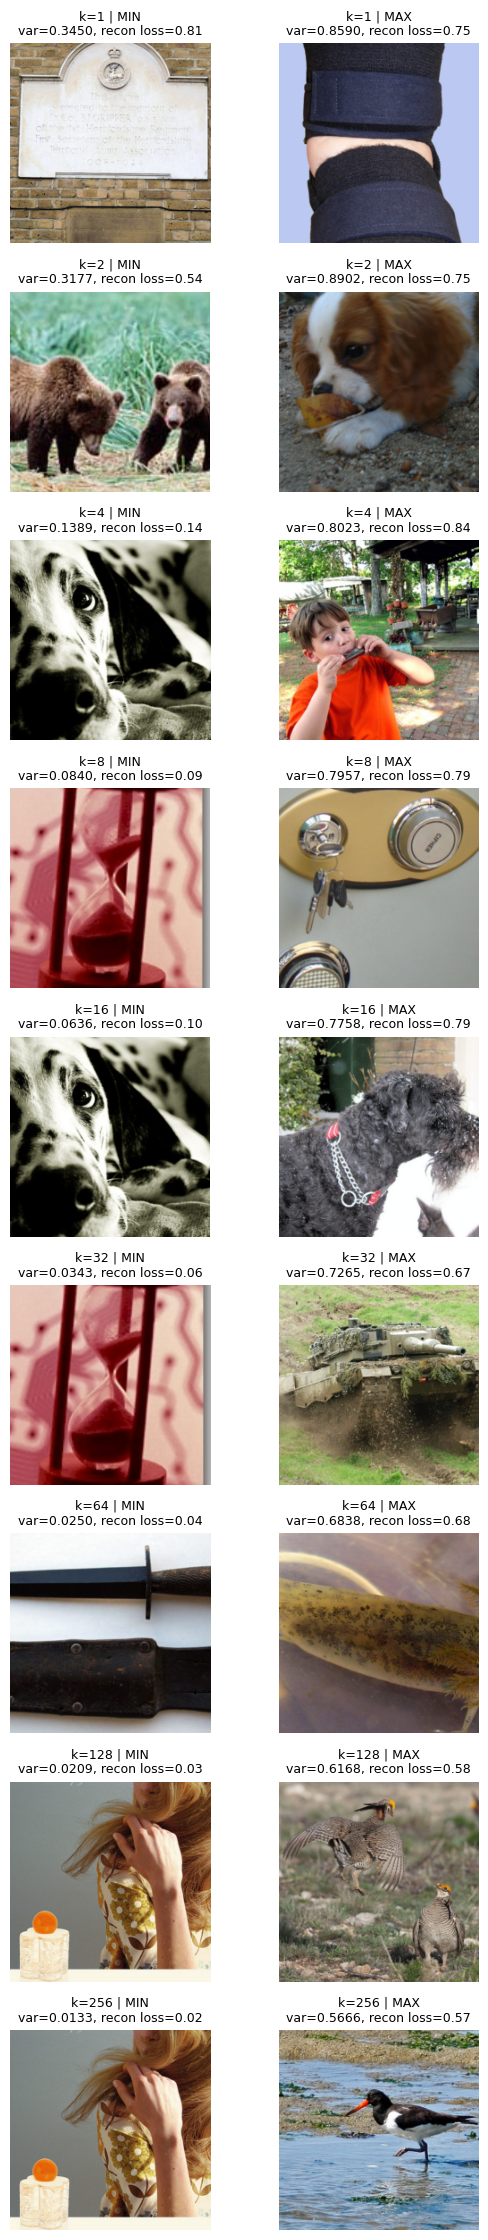

In [43]:

num_k = len(images_by_k)

fig, axes = plt.subplots(
    num_k, 2,
    figsize=(6, 2.5 * num_k),
    squeeze=False
)

for row, (k, data) in enumerate(images_by_k.items()):
    for col, key in enumerate(["min", "max"]):
        ax = axes[row, col]
        img = data[key]["image"]
        var = data[key]["variance"]
        img_id = data[key]["image_id"]
        rl = data[key]["lpips_recon_loss"]

        ax.imshow(img)
        ax.axis("off")

        ax.set_title(
            f"k={k} | {key.upper()}\n"
            f"var={var:.4f}, recon loss={rl:.2f}",
            fontsize=9
        )

axes[0, 0].set_ylabel("Lowest LPIPS", fontsize=10)
axes[0, 1].set_ylabel("Highest LPIPS", fontsize=10)

plt.tight_layout()
plt.savefig("/BS/data_mani_compress/work/thesis/thesis/output/variance_in_reconstruction/highest_lowest_var.pdf")
plt.show()

In [ ]:
# plot the 8 reconstructions for the images with highest and lowest reconstruction loss for each k

